# Batch correction 

Batch correction with MNN.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


First need to load the QC filtered dataset and create individual adata objects per batch.

In [2]:
# Load the stored data object
save_file = './../write/scanpy/qc_filtered_3pbmc.h5ad'
adata = sc.read_h5ad(save_file)


In [3]:
adata

AnnData object with n_obs × n_vars = 2530 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'lib_prep_colors'

As the stored AnnData object contains scaled data, we need to reset the adata.X object to the raw counts and renormalized. Variable gene selection should not be performed on the scaled data object, only do normalization and log transformation before variable genes selection. 

In [4]:
adata.X = adata.raw.X

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Detect variable genes

Variable genes can be detected across the full dataset, but then we run the risk of getting many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. Here, we will do both as an example of how it can be done. 

First we will select genes based on the full dataset.

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


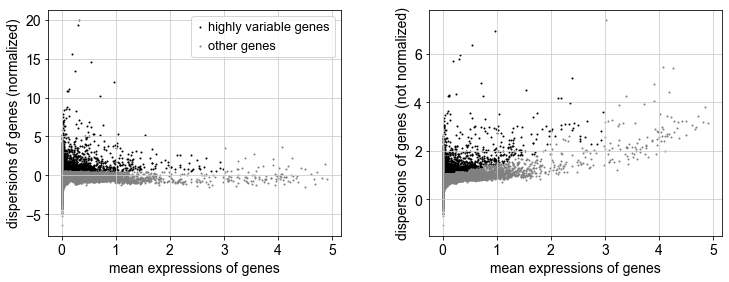

Highly variable genes: 2330


In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata)

print("Highly variable genes: %d"%sum(adata.var.highly_variable))

var_genes_all = adata.var.highly_variable

Detect variable genes in each dataset separately using the batch_key parameter.

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'lib_prep')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 707
Number of batches where gene is variable:
0    10970
1     3828
2     1261
3      707
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [7]:
print("Batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata.var.highly_variable_intersection))


Batch var genes: 5796
All data var genes: 0
Overlap: 0
Overlap batch instersection and all: 0


Select all genes that are variable in at least 2 datasets and use for remaining analysis. 

In [8]:
var_select = adata.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]



### Data integration

First we need to create individual AnnData objects from each of the datasets.

In [9]:
# split per batch into new objects.
batches = ['v2','v3','p3']
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['lib_prep'] == batch,]

alldata    

{'v2': View of AnnData object with n_obs × n_vars = 933 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'S_score', 'G2M_score', 'phase'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'lib_prep_colors',
 'v3': View of AnnData object with n_obs × n_vars = 1071 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'S_score', 'G2M_score', 'phase'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'lib_prep_colors',
 'p3': View of AnnData object with n_obs × n_vars = 526 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'S_score', 'G2M_score', 'phase'
     var: 'gene_ids', 'featu

In [10]:
#alldata['v2'].var.index
vg = [x for x in var_genes if x in adata.var.index]
len(vg)
type(var_genes)

pandas.core.indexes.base.Index

Then perform batch correction with MNN. 

The function mnn_correct has the following input options:

```    
scanpy.api.pp.mnn_correct(*datas, var_index=None, var_subset=None, 
 batch_key='batch', index_unique='-', batch_categories=None, k=20, 
 sigma=1.0, cos_norm_in=True, cos_norm_out=True, svd_dim=None, 
 var_adj=True, compute_angle=False, mnn_order=None, svd_mode='rsvd', 
 do_concatenate=True, save_raw=False, n_jobs=None, **kwargs)
```

We run it with the option `save_raw=True` so that the uncorrected matrix will be stored in the slot `raw`.

In [11]:
cdata = sc.external.pp.mnn_correct(alldata['v2'],alldata['v3'],alldata['p3'], batch_key = 'lib_prep', save_raw = True, var_subset = var_genes)



Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


The mnn_correct function returns a tuple with the AnnData object, list of cell pairs and of angles. Hence, `cdata[0]` is the new AnnData object.  

We get corrected expression values for all genes even though only the selected genes were used for finding neighbor cells. For later analysis we want to do dimensionality reduction etc. on the variable genes only, so we will subset the data to only include the variable genes.




In [12]:
corr_data = cdata[0][:,var_genes]

In [13]:
print(corr_data.raw.shape)
print(corr_data.shape)

(2530, 16766)
(2530, 1968)


Now, lets save the batch corrected dataset to a file for further analysis.

In [14]:
save_file = './../write/scanpy/mnn_corrected_3pbmc.h5ad'
corr_data.write_h5ad(save_file)

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


Also save the full data to a file in case you want to do clustering on 

For comparison later on, also create a normalized and scaled data object for the non-corrected dataset using the variable genes across all datasets. As we have already subsetted the adata object to the variable genes per batch, we will need to rerun those steps. 

In [15]:
save_file = './../write/scanpy/qc_filtered_3pbmc.h5ad'
adata = sc.read_h5ad(save_file)
# again, take all raw data as the expression matrix.
adata.X = adata.raw.X

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata = adata[:, adata.var['highly_variable']]


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Also, regress out number of counts and percent mitochondrial reads. 

In [16]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


And finally do the scaling of the data and save to a file.

In [17]:
sc.pp.scale(adata, max_value=10)


In [18]:
save_file = './../write/scanpy/uncorrected_3pbmc.h5ad'
adata.write_h5ad(save_file)